# Imports

In [1]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize

from IPython.display import clear_output

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Data Loading

In [2]:
def shuffle_split (all_dirs, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int (len (all_dirs) * val_pct)
    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]
    
    return all_dirs [n_val:], all_dirs [:n_val]

In [3]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__ (self, index):
        imgs_path = self.img_dirs [index]
        image = self.concat_imgs (imgs_path)
        mask = np.array (Image.open (f'{imgs_path}/seg.jpg'))
        mask = (mask / 255 * 4).round ()
        mask = self.preprocess_mask_labels(mask)
        
        `
        if self.transform is not None:
            augmented = self.transform(image = image, mask = mask)
            image = augmented ['image']
            mask = augmented ['mask']

        return image.astype(np.float32), mask.astype(np.float32)

    def concat_imgs (self, path: str):
        types = []
        for modality_type in modality_types:
            img = np.array (Image.open (f'{path}/{modality_type}.jpg'))
            img = self.normalize(img)
            types.append (img)
#         cat_img = np.concatenate (types, axis = -1)

        return np.array(types)
    
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1
       
        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1
        
        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
        return mask
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min 
        
        return (data - data_min) / (np.max(data) - data_min)

    trn_tfms = A.Compose (
[
    A.Resize (height = 240, width = 240),
    #     A.Rotate (limit = 35, p = 1.0),
    #     A.HorizontalFlip (p = 0.5),
    #     A.VerticalFlip (p = 0.1),
        # A.Normalize (mean=0.5, std=0.5, max_pixel_value = 255.0), 
            # img = (img - mean * max_pixel_value) / (std * max_pixel_value)
    #     ToTensorV2 ()
            # The numpy HWC image is converted to pytorch CHW tensor. If the image is in HW format (grayscale image), it will be converted to pytorch HW tensor.
])

val_tfms = A.Compose (
[
    A.Resize (height = 240, width = 240),
    #     A.Normalize (0.5, 0.5, max_pixel_value = 255.0),
    #     ToTensorV2 ()
])

modality_types = ['flair', 't1', 't1ce', 't2']

In [4]:
imgs_dir='./BraTs'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()
# test_dirs = np.copy(all_dirs[45000:])
# all_dirs = all_dirs[:45000]
# len(all_dirs), all_dirs[:10]

train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
len(valid_dirs), len(train_dirs)

(38, 218)

In [5]:
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)

## Dataset visualization

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


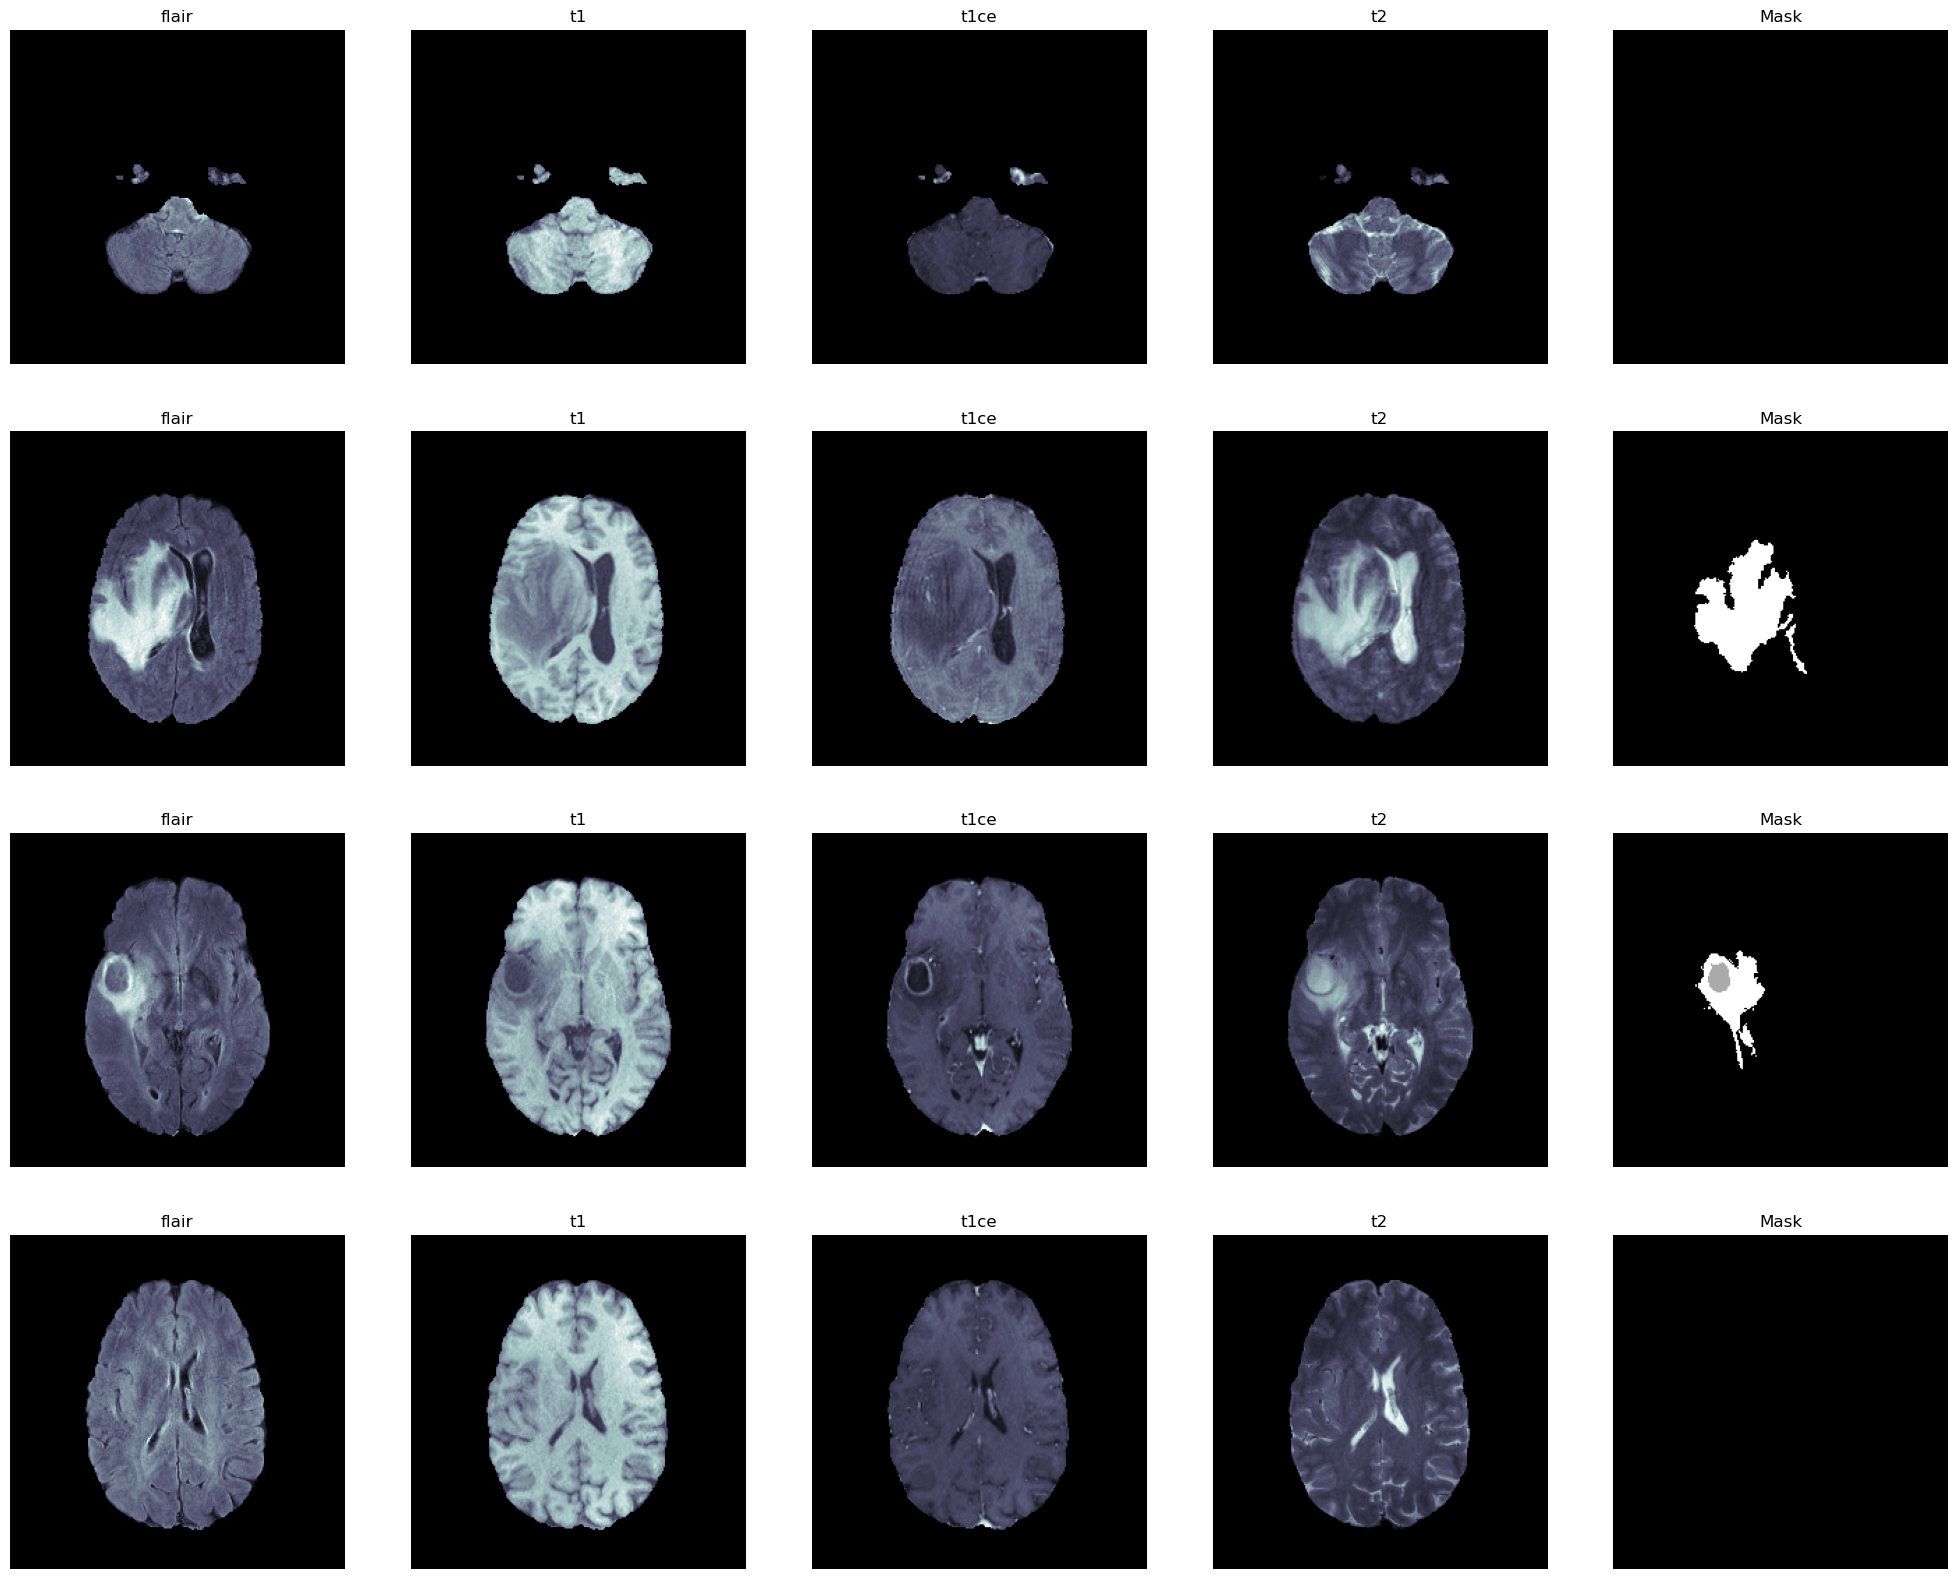

In [27]:
for i, (imgs, msks) in enumerate(train_dl):
    if i == 4:
        break

print(imgs.shape)
print(msks.shape)

idx = np.random.permutation(imgs.shape[0])
imgs = imgs[idx]
msks = msks[idx]

# Setting up the figure for displaying images and masks
plt.figure(figsize=(25, 20))
for i in range(4):
    for j in range(len(modality_types)):
        plt.subplot(4, 5, 5 * i + j + 1)
        plt.imshow(imgs[i][j].numpy(), cmap='bone')  # Assuming imgs are PyTorch tensors
        plt.axis('off')
        plt.title(modality_types[j])
    plt.subplot(4, 5, 5 * i + 5)
    # Assuming masks are in one-hot format and need to be converted to a single label per pixel
    plt.imshow(256 - (np.argmax(msks[i].numpy(), axis=0) * 80), cmap='gray')
    plt.axis('off')
    plt.title('Mask')

plt.show()

# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.activation = nn.Softmax()
    def forward(self, x):
        return self.conv(x)
        # return self.activation(self.conv(x))


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Loss and Metrics

In [7]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# Trainer

In [30]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl 
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, (images, targets) in enumerate(dataloader):
#             print(images.shape, targets.shape)
#             images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

# Model Initialization

In [8]:
batch_size = 8
# train_dirs=train_dirs[:200]
# valid_dirs=valid_dirs[:200]
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)
print(len(valid_dl ), len(train_dl))
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device).float()

5 28


In [9]:
checkpoint = torch.load("./unet-2d.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Evaluation

In [10]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
#             imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            

            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [11]:
valid_ds = BratsDataset(valid_dirs, modality_types)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)

In [11]:
model.eval();

In [22]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, valid_dl, ['WT', 'TC', 'ET', 'BG']
    )

CPU times: user 1min 1s, sys: 4.18 s, total: 1min 5s
Wall time: 10.3 s


In [23]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard,BG dice,BG jaccard
18,0.65764,0.489914,1.0,1.0,1.0,1.0,0.998875,0.997752
31,1.00000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
5,0.57346,0.401993,1.0,1.0,1.0,1.0,0.998876,0.997754
8,1.00000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
1,1.00000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000


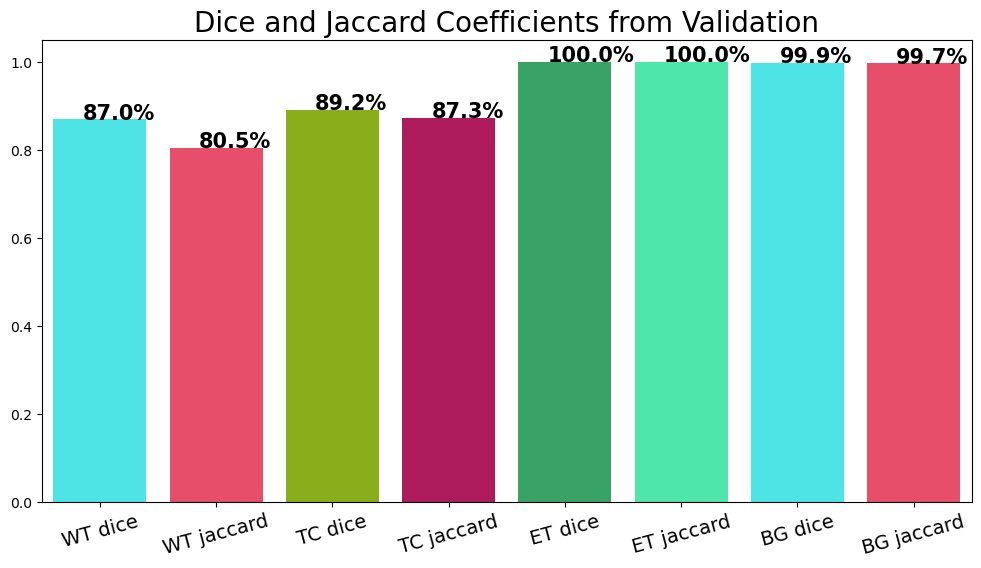

In [24]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

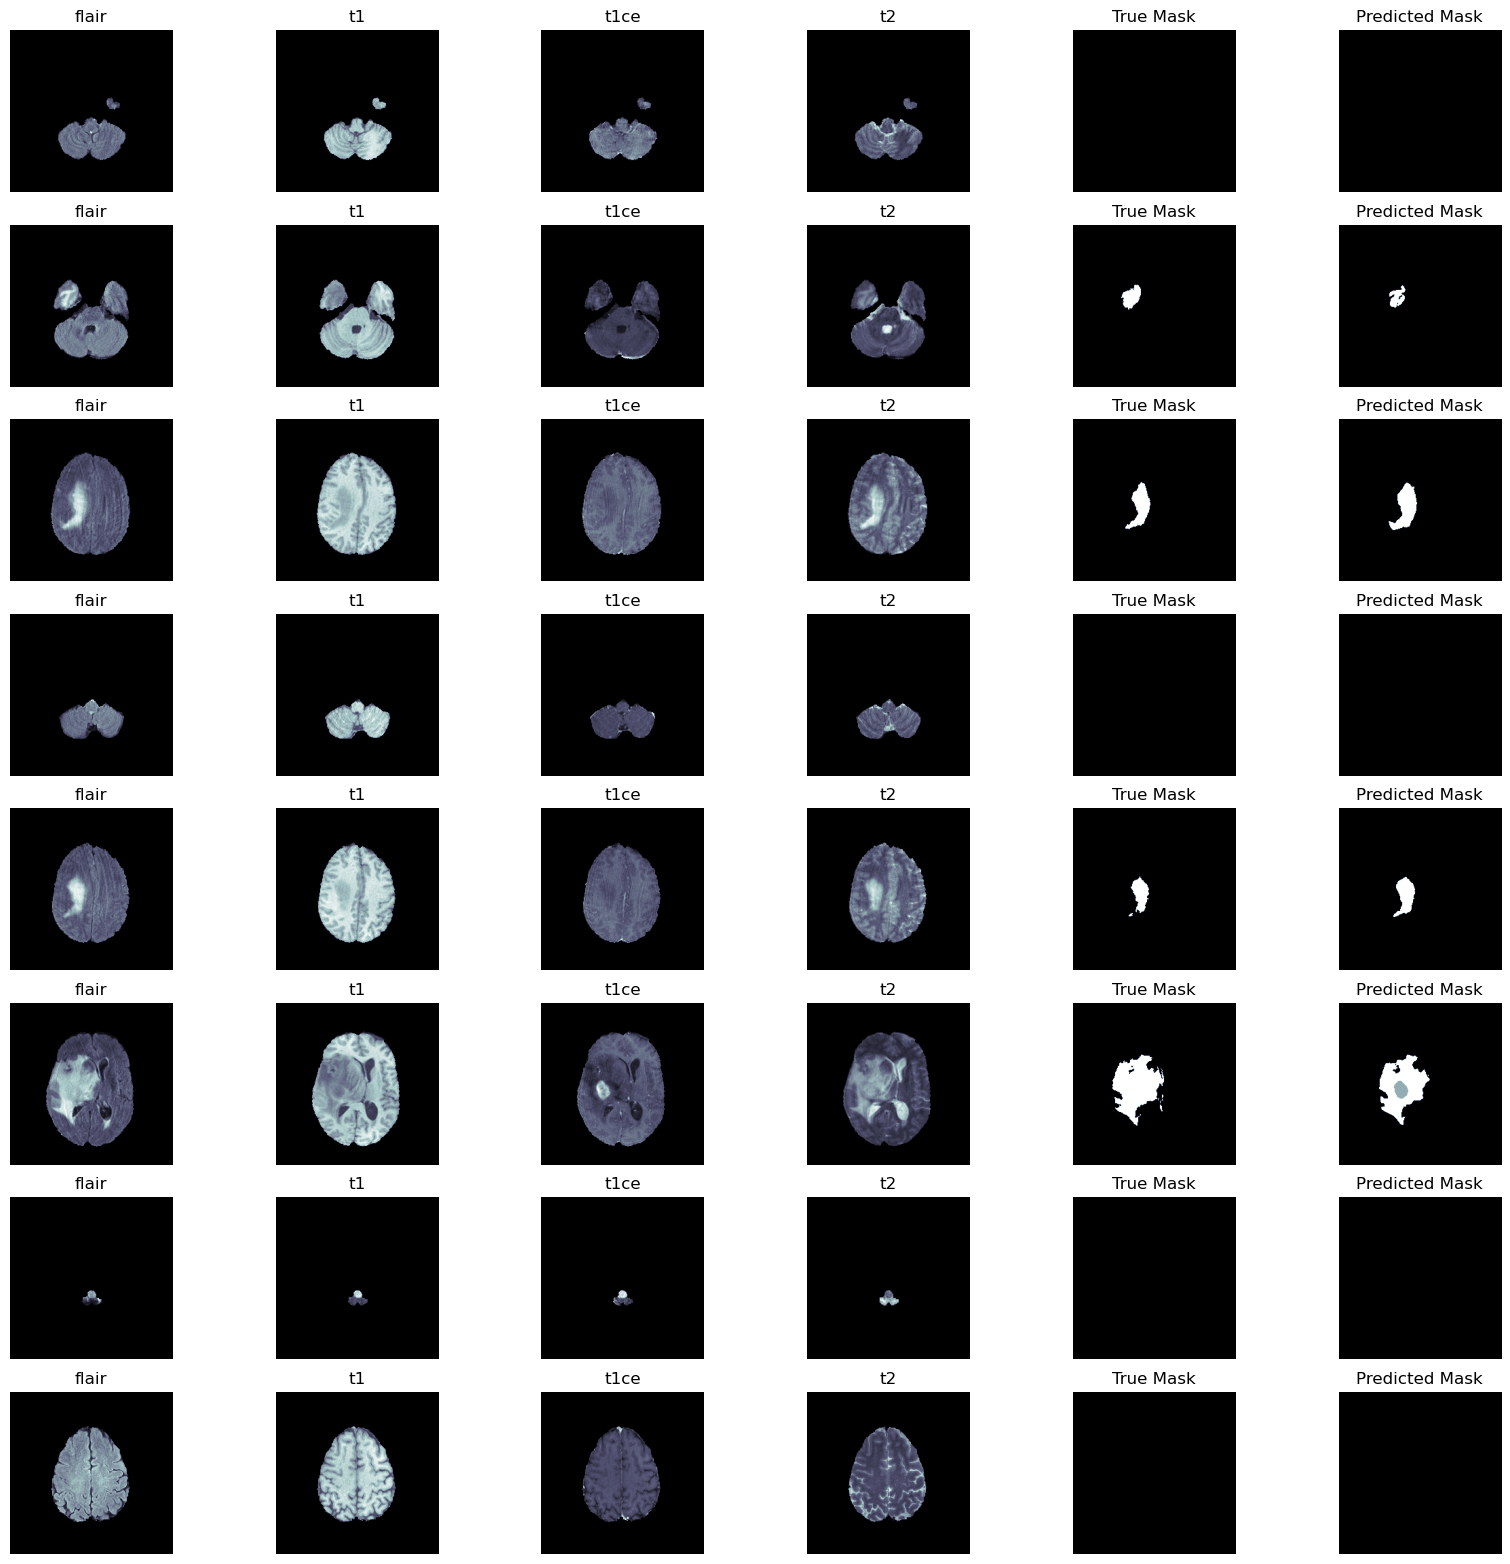

In [ ]:
def show_results (model, test_dl, checkpoint_path = None):
    """ showing image, mask and predicted mask for one batch """
    if checkpoint_path is not None:
        load_checkpoint (torch.load (checkpoint_path), model)
    dl = iter(test_dl)
#     dl.next()
#     dl.next()
#     dl.next()
#     dl.next()
#     dl.next()
#     dl.next()
#     dl.next()
    images, masks = next(dl)

    for BB in range(4):
        images, masks = next(dl)
        images = images.to(device)
        masks = masks.to(device)
        outputs = model (images.float())

        preds = torch.argmax (outputs, dim = 1)
        masks = torch.argmax (masks, dim = 1)
#         print(torch.unique(preds), torch.unique(masks))
        masks = masks*84
        preds = preds*84

        mean = 0.5
        std = 0.5
        plt.figure (figsize = (20, 40))
        for i in range (8):
            for j in range (len (modality_types)):
                # show all type of images
                plt.subplot (16, 6, 6 * i + j + 1)
                plt.axis ('off')
                plt.title (modality_types [j])
    #             image = gpu_to_cpu (images [i][j], std, mean)
                plt.imshow (images [i][j].cpu(), cmap = 'bone')
            # show True Mask
            plt.subplot (16, 6, 6 * i + 5)
            plt.title ('True Mask')
            plt.axis ('off')
            plt.imshow (255 - masks[i].cpu(), cmap = 'bone')
            # show Predicted Mask
            plt.subplot (16, 6, 6 * i + 6)
            plt.title ('Predicted Mask')
            plt.axis ('off')
    #         pred = gpu_to_cpu (preds [i], std, mean)
            plt.imshow (255 - preds[i].cpu(), cmap = 'bone')

        plt.show ()
    return masks, preds
show_results (model, valid_dl, checkpoint_path = None)

# Captum

In [12]:
dl = DataLoader(train_ds, batch_size = 1, shuffle = False, num_workers = 2, pin_memory = True)

In [13]:
model.eval()

import torch
from captum.attr import FeatureAblation
from captum.attr import visualization as viz

/home/renzhamin/.conda/envs/captum/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
images, targets = next(iter(dl))

In [15]:
logits = model(images.float())

In [16]:
out_max = torch.argmax(logits, dim=1, keepdim=True)

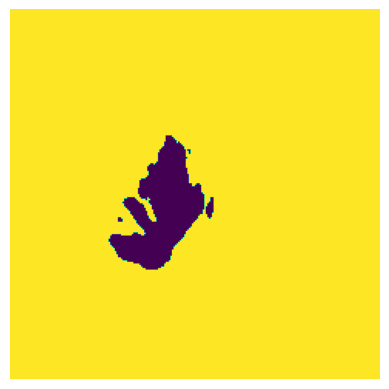

In [28]:
plt.imshow(out_max[0, 0,:]); plt.axis('off'); plt.show()

In [ ]:
# Initialize Feature Ablation
feature_ablation = FeatureAblation(model)

attributions = feature_ablation.attribute(images, feature_mask = out_max, target=0, n_steps=1)  # You can change target as needed

# Since the output will be smaller than the input image, we need to upsample it
# upsampled_attributions = LayerAttribution.interpolate(attributions, images.shape[2:])

In [ ]:
# Visualize the attributions
for idx in range(images.shape[0]):
    attr = attributions_ig[idx].cpu().detach().numpy()
    img = images[idx].cpu().detach().numpy()
    viz.visualize_image_attr(attr, img, method="heat_map", sign="all", show_colorbar=True)

In [23]:
images[0, :].shape

torch.Size([4, 240, 240])

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

# Create an instance of Integrated Gradients
ig = IntegratedGradients(model)

# Get some data
dataiter = iter(dl)
images, masks = next(dataiter)
images, masks = images.to(device), masks.to(device)

# Choose the target class for which gradients should be calculated 
# For instance, for binary segmentation, you could pick class index 1 (foreground class)
target = masks.argmax(dim = 1)  # Assuming your model outputs raw logits

# Compute the attribute
# attributions_ig = ig.attribute(images.float(), target=target, n_steps=1)
attributions_ig = ig.attribute(images.float(), n_steps=1)

In [ ]:
import torch
from captum.attr import DeepLift
from captum.attr import visualization as viz

model.eval()
# Assuming you have a DataLoader with a manageable batch size
images, targets = next(iter(dl))

# Initialize DeepLift
deeplift = DeepLift(model)

# Using a zero baseline; ensure the shape matches your input shape
baseline = torch.zeros_like(images)

# Assuming you want to focus on a particular class for each image,
# you can specify a tensor of class indices where each index corresponds to the target class for each image.
# For example, if you have a batch of 2 and you want to look at class 0 for the first image and class 1 for the second:
target_indices = torch.tensor([0, 1], dtype=torch.int32)

# Calculate DeepLIFT attributions using these indices
attributions_dl = deeplift.attribute(images, baselines=baseline, target=target_indices)

In [ ]:
dice_scores = dice_coef_metric_per_classes(logits, targets)

In [ ]:
# Visualization of the first input
attributed_img = np.transpose(attributions_ig.cpu().numpy()[0], (1, 2, 0))
original_img = np.transpose(images.cpu().numpy()[0], (1, 2, 0))

In [31]:
# Use Captum's visualization utility to visualize the attribution
viz.visualize_image_attr(attributed_img, original_img, method='heat_map', sign='all', show_colorbar=True, title='Integrated Gradients')